In [1]:
# Alina Artemiuk
from torchvision import datasets, transforms
from sklearn.metrics import accuracy_score
from torch.utils.data import random_split
from collections import Counter
import torch.optim as optim
import torch.nn as nn
import torch

from datetime import datetime
import matplotlib.pyplot as plt
import numpy as np

SEED = 265
torch.manual_seed(SEED)
torch.set_default_dtype(torch.double)

1. Load, analyse and preprocess the CIFAR-10 dataset. Split it into 3 datasets: training, validation and test. Take a subset of these datasets by keeping only 2 labels: bird and plane.

In [2]:
def load_cifar(train_val_split=0.9, data_path='../data/', preprocessor=None):
    # Define preprocessor if not already given
    if preprocessor is None:
        preprocessor = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize((0.4915, 0.4823, 0.4468),
                                 (0.2470, 0.2435, 0.2616))
        ])

    # load datasets
    data_train_val = datasets.CIFAR10(data_path, train=True, download=True, transform=preprocessor)
    data_test = datasets.CIFAR10(data_path, train=False, download=True, transform=preprocessor)

    # train/validation split
    n_train = int(len(data_train_val) * train_val_split)
    n_val = len(data_train_val) - n_train

    data_train, data_val = random_split(data_train_val, [n_train, n_val], generator=torch.Generator().manual_seed(SEED))

    print("CIFAR-10:")
    print("Size of the train dataset:", len(data_train))
    print("Size of the validation dataset:", len(data_val))
    print("Size of the test dataset:", len(data_test))

    return data_train, data_val, data_test

In [3]:
def compute_statistics(data):
    imgs = torch.cat([img for img, _ in data])
    mean = torch.mean(imgs).item()
    std = torch.std(imgs).item()
    amin = torch.min(imgs).item()
    amax = torch.max(imgs).item()
    print("Mean: ", mean)
    print("Std:  ", std)
    print("Min:  ", amin)
    print("Max:  ", amax)


def analyse_dataset(data):
    compute_statistics(data)
    counter = Counter([int(label) for _, label in data])
    c = counter.most_common()
    print(f"\nNumber of classes:               {len(c)}")
    print(f"Biggest class:   {c[0][0]}   occurrence:  {c[0][1]}")
    print(f"Smallest class:  {c[-1][0]}   occurrence:  {c[-1][1]}")

    return counter

In [4]:
cifar10_train, cifar10_val, cifar10_test = load_cifar()
label_map = {0: 0, 2: 1}
class_names = ['plane', 'bird']

# For each dataset, keep only planes and birds
cifar2_train = [(img, label_map[label]) for img, label in cifar10_train if label in [0, 2]]
cifar2_val = [(img, label_map[label]) for img, label in cifar10_val if label in [0, 2]]
cifar2_test = [(img, label_map[label]) for img, label in cifar10_test if label in [0, 2]]

print("\n" + "-" * 20 + "\n")
print("CIFAR-2:")
print('Size of the training dataset:', len(cifar2_train))
print('Size of the validation dataset:', len(cifar2_val))
print('Size of the test dataset:', len(cifar2_test))

Files already downloaded and verified
Files already downloaded and verified
CIFAR-10:
Size of the train dataset: 45000
Size of the validation dataset: 5000
Size of the test dataset: 10000

--------------------

CIFAR-2:
Size of the training dataset: 8987
Size of the validation dataset: 1013
Size of the test dataset: 2000


In [5]:
# Extract one image and one label from the dataset
img, label = cifar2_train[0]

print('Shape of the input:', img.shape)
print('Type of the input:', img.dtype)
print('Type of the target:', type(label))

Shape of the input: torch.Size([3, 32, 32])
Type of the input: torch.float64
Type of the target: <class 'int'>


In [6]:
print("------- Training dataset ------- ")
counter_train = analyse_dataset(cifar2_train)
print("\n ------- Validation dataset ------- ")
counter_val = analyse_dataset(cifar2_val)
print("\n ------- Test dataset ------- ")
counter_test = analyse_dataset(cifar2_test)

n_classes = len(counter_train)

weights = [counter_train[i] / counter_train.total() for i in range(n_classes)]
print("Class weigths:", weights)

imgs_train = torch.cat([img for img, _ in cifar2_train])
mean = torch.mean(imgs_train).item()
std = torch.std(imgs_train).item()
print(f"Normalize with:\nMean    {round(mean, 4)}\nStd     {round(std, 4)}")
normalizer = transforms.Normalize(mean, std)

------- Training dataset ------- 
Mean:  0.15290364818471697
Std:   0.988775818093511
Min:   -1.9898785425101215
Max:   2.1260780287474335

Number of classes:               2
Biggest class:   1   occurrence:  4512
Smallest class:  0   occurrence:  4475

 ------- Validation dataset ------- 
Mean:  0.19588418875814312
Std:   0.9741871108328097
Min:   -1.9898785425101215
Max:   2.1260780287474335

Number of classes:               2
Biggest class:   0   occurrence:  525
Smallest class:  1   occurrence:  488

 ------- Test dataset ------- 
Mean:  0.1871463312322955
Std:   0.9854780704601382
Min:   -1.9898785425101215
Max:   2.1260780287474335

Number of classes:               2
Biggest class:   0   occurrence:  1000
Smallest class:  1   occurrence:  1000
Class weigths: [0.4979414710136864, 0.5020585289863135]
Normalize with:
Mean    0.1529
Std     0.9888


2. Write a MyMLP class that implements a MLP in PyTorch (so only fully connected layers) such that:
(a) The input dimension is 3072 (= 32 * 32 * 3) and the output dimension is 2 (for the 2 classes).
(b) The hidden layers have respectively 512, 128 and 32 hidden units.
(c) All activation functions are `ReLU`. The last layer has no activation function since the cross-entropy loss already includes a softmax activation function.

In [7]:
class MyMLP(nn.Module):
    def __init__(self):
        super(MyMLP, self).__init__()
        self.fc1 = nn.Linear(3072, 512)
        self.fc2 = nn.Linear(512, 128)
        self.fc3 = nn.Linear(128, 32)
        self.fc4 = nn.Linear(32, 2)

    def forward(self, x):
        out = torch.flatten(x, 1)  # flatten the input tensor
        out = torch.relu(self.fc1(out))
        out = torch.relu(self.fc2(out))
        out = torch.relu(self.fc3(out))
        out = self.fc4(out)
        return out

In [8]:
def set_device(device=None):
    if device is None:
        device = (torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu'))
        print(f"On device {device}.")
    return device

3. Write a `train(n_epochs, optimizer, model, loss_fn, train_loader)` function that trains model for `n_epochs` epochs given an optimizer `optimizer`, a loss function `loss_fn` and a dataloader `train_loader`.

In [9]:
def train(n_epochs, optimizer, model, loss_fn, train_loader, val_loader, device=None, preprocessor=normalizer):
    print("\n --------- Using Pytorch's SGD ---------")
    device = set_device(device)

    n_batch_train = len(train_loader)
    n_batch_val = len(val_loader)

    losses_train = []
    losses_val = []

    model.train()
    optimizer.zero_grad(set_to_none=True)

    for epoch in range(1, n_epochs + 1):
        loss_train = 0

        for imgs, labels in train_loader:
            imgs = preprocessor(imgs.to(device=device, dtype=torch.double))
            labels = labels.to(device=device)

            outputs = model(imgs)

            loss = loss_fn(outputs, labels)
            loss.backward()

            optimizer.step()
            optimizer.zero_grad()

            loss_train += loss.item()

        losses_train.append(loss_train / n_batch_train)

        model.eval()

        with torch.no_grad():
            loss_val = 0.0
            for imgs, labels in val_loader:
                imgs = preprocessor(imgs.to(device=device, dtype=torch.double))
                labels = labels.to(device=device)

                outputs = model(imgs)
                loss_val += loss_fn(outputs, labels).item()

        losses_val.append(loss_val / n_batch_val)

        if epoch == 1 or epoch % 5 == 0:
            print(f'{datetime.now().time()}  |  Epoch {epoch}  |  Training loss {round(loss_train / n_batch_train, 5)}')

    return losses_train, losses_val

4. Write a similar function `train_manual_update` that has no `optimizer` parameter, but a learning rate `lr` parameter instead and that manually updates each trainable parameter of model using equation (3). Do not forget to zero out all gradients after each iteration.
5. Train 2 instances of `MyMLP`, one using `train` and the other using `train_manual_update` (use the same parameter values for both models). Compare their respective training losses. To get exactly the same results with both functions, see section 3.3.
6. Modify train_manual_update by adding a L2 regularization term in your manual parameter update. Add an additional `weight_decay` parameter to `train_manual_update`. Compare again `train` and `train_manual_update` results with 0 < `weight_decay` < 1.
7. Modify `train_manual_update` by adding a momentum term in your parameter update. Add an additional `momentum` parameter to `train_manual_update`. Check again the correctness of the new update rule by comparing it to `train` function (with 0 < `momentum` < 1)

In [10]:
def train_manual_update(n_epochs, lr, model, loss_fn, train_loader, val_loader, weight_decay=0, momentum=0, device=None,
                        preprocessor=normalizer):
    print("\n --------- Using Manual Parameter Update ---------")
    device = set_device(device)
    n_batch_train = len(train_loader)
    n_batch_val = len(val_loader)

    losses_train = []
    losses_val = []

    velocities = {}

    model.train()
    model.zero_grad(set_to_none=True)

    for epoch in range(1, n_epochs + 1):
        loss_train = 0

        for imgs, labels in train_loader:
            imgs = preprocessor(imgs.to(device=device, dtype=torch.double))
            labels = labels.to(device=device)

            outputs = model(imgs)

            loss = loss_fn(outputs, labels)
            loss.backward()

            with torch.no_grad():
                for name, p in model.named_parameters():
                    grad = p.grad

                    if weight_decay:
                        grad += weight_decay * p.data

                    if momentum:
                        if name in velocities:
                            buffer = velocities[name]
                            buffer.mul_(momentum).add_(grad)
                        else:
                            buffer = velocities[name] = torch.clone(grad).detach()
                        grad = buffer

                    p.data -= grad * lr

                model.zero_grad()

            loss_train += loss.item()

        losses_train.append(loss_train / n_batch_train)

        model.eval()

        with torch.no_grad():
            loss_val = 0.0
            for imgs, labels in val_loader:
                imgs = preprocessor(imgs.to(device=device))
                labels = labels.to(device=device)

                outputs = model(imgs)
                loss_val += loss_fn(outputs, labels).item()

        losses_val.append(loss_val / n_batch_val)

        if epoch == 1 or epoch % 5 == 0:
            print(f'{datetime.now().time()}  |  Epoch {epoch}  |  Training loss {round(loss_train / n_batch_train, 5)}')

    return losses_train, losses_val

8. Train different instances (at least 4) of the `MyMLP` model with different learning rate, momentum and weight decay values. For hyperparameters values, you can find inspiration in the `gradient_descent_output.txt` file. Note that having different results than in this file is totally normal (e.g. if you had a different dataset split policy than the one used to create this file). However, your `train_manual_update` and `train` functions should give exactly the same results (as we can observe in `gradient_descent_output.txt`).


In [11]:
n_epochs = 30
batch_size = 256

lr = 0.01
momentum = [0, 0, 0.9, 0.9, 0.9, 0.8]
weight_decay = [0, 0.01, 0, 0.01, 0.001, 0.01]

train_models, manual_train_models = [], []
losses_train_train, losses_val_train = [], []
losses_train_manual_train, losses_val_manual_train = [], []

device = set_device()

train_loader = torch.utils.data.DataLoader(cifar2_train, batch_size=batch_size, shuffle=False)
val_loader = torch.utils.data.DataLoader(cifar2_val, batch_size=batch_size, shuffle=False)
loss_fn = nn.CrossEntropyLoss()

for m, w_d in zip(momentum, weight_decay):
    print("=" * 58)
    print(f"""   Current parameters:
lr = {lr}
mom = {m}
decay = {w_d}""")
    torch.manual_seed(SEED)
    model_t = MyMLP()
    model_train = model_t.to(device=device)
    optimizer = optim.SGD(model_train.parameters(), lr=lr, weight_decay=w_d, momentum=m)

    torch.manual_seed(SEED)
    model_m_t = MyMLP()
    model_manual_train = model_m_t.to(device=device)

    loss_train_train, loss_val_train = train(n_epochs, optimizer, model_train, loss_fn, train_loader, val_loader)
    loss_train_manual_train, loss_val_manual_train = train_manual_update(n_epochs, lr, model_manual_train, loss_fn,
                                                                         train_loader, val_loader, w_d, m)

    train_models.append(model_t)
    manual_train_models.append(model_m_t)
    losses_train_train.append(loss_train_train)
    losses_val_train.append(loss_val_train)
    losses_train_manual_train.append(loss_train_manual_train)
    losses_val_manual_train.append(loss_val_manual_train)

On device cpu.
   Current parameters:
lr = 0.01
mom = 0
decay = 0

 --------- Using Pytorch's SGD ---------
On device cpu.
21:46:16.367150  |  Epoch 1  |  Training loss 0.67971
21:46:25.382706  |  Epoch 5  |  Training loss 0.53734
21:46:34.218145  |  Epoch 10  |  Training loss 0.45834
21:46:43.046753  |  Epoch 15  |  Training loss 0.41827
21:46:51.984813  |  Epoch 20  |  Training loss 0.38175
21:47:00.800974  |  Epoch 25  |  Training loss 0.34832
21:47:09.601793  |  Epoch 30  |  Training loss 0.31436

 --------- Using Manual Parameter Update ---------
On device cpu.
21:47:11.509688  |  Epoch 1  |  Training loss 0.67971
21:47:19.149729  |  Epoch 5  |  Training loss 0.53734
21:47:28.568096  |  Epoch 10  |  Training loss 0.45834
21:47:38.044526  |  Epoch 15  |  Training loss 0.41827
21:47:47.491041  |  Epoch 20  |  Training loss 0.38175
21:47:57.139093  |  Epoch 25  |  Training loss 0.34832
21:48:06.622601  |  Epoch 30  |  Training loss 0.31436
   Current parameters:
lr = 0.01
mom = 0
dec

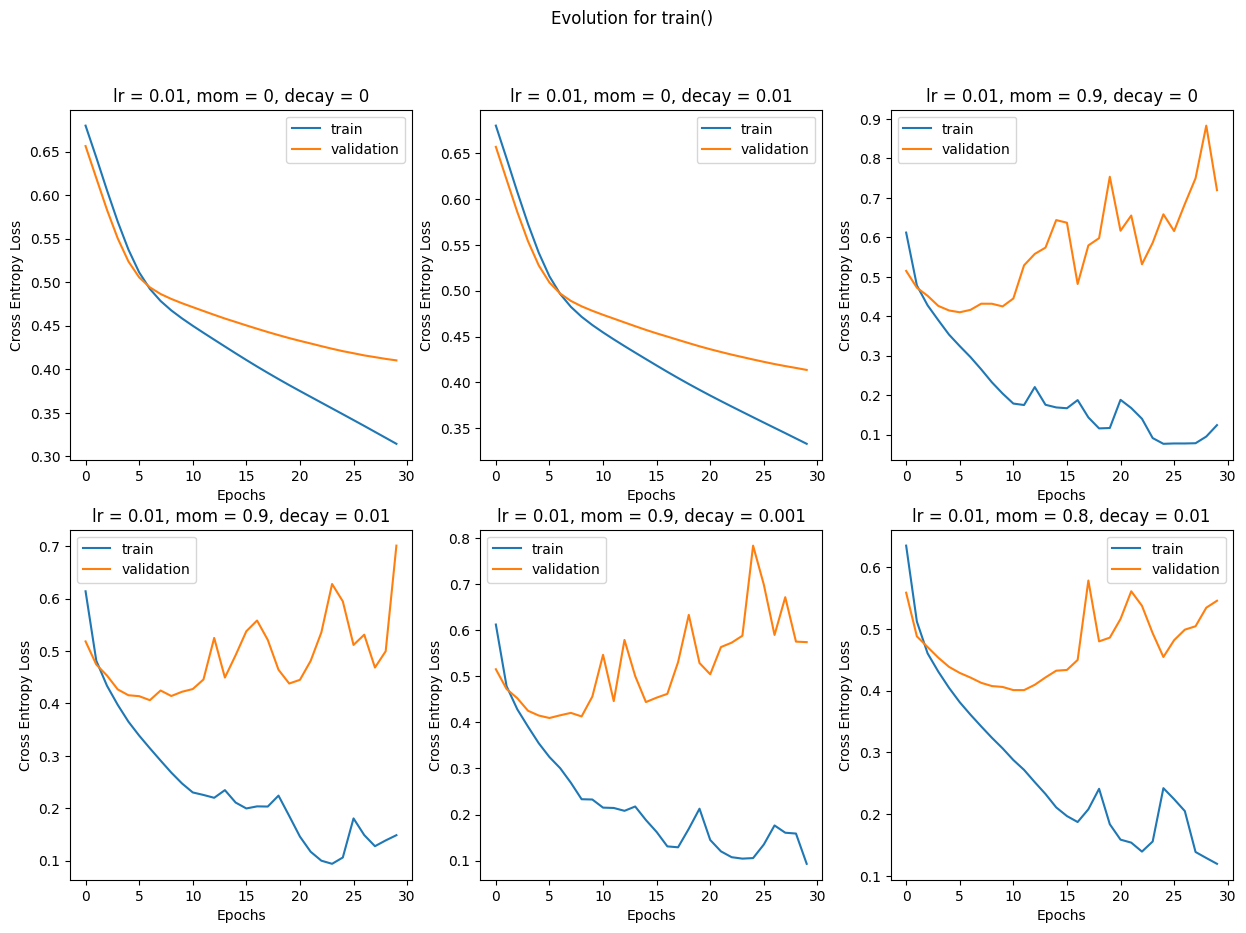

In [12]:
fig, axes = plt.subplots(2, 3, figsize=(15, 10))

for i, ax in enumerate(axes.flat):
    ax.plot(losses_train_train[i], label='train')
    ax.plot(losses_val_train[i], label='validation')
    ax.set_title(f"lr = {lr}, mom = {momentum[i]}, decay = {weight_decay[i]}")
    ax.set_xlabel('Epochs')
    ax.set_ylabel('Cross Entropy Loss')
    ax.legend()
fig.suptitle("Evolution for train()")
plt.show()

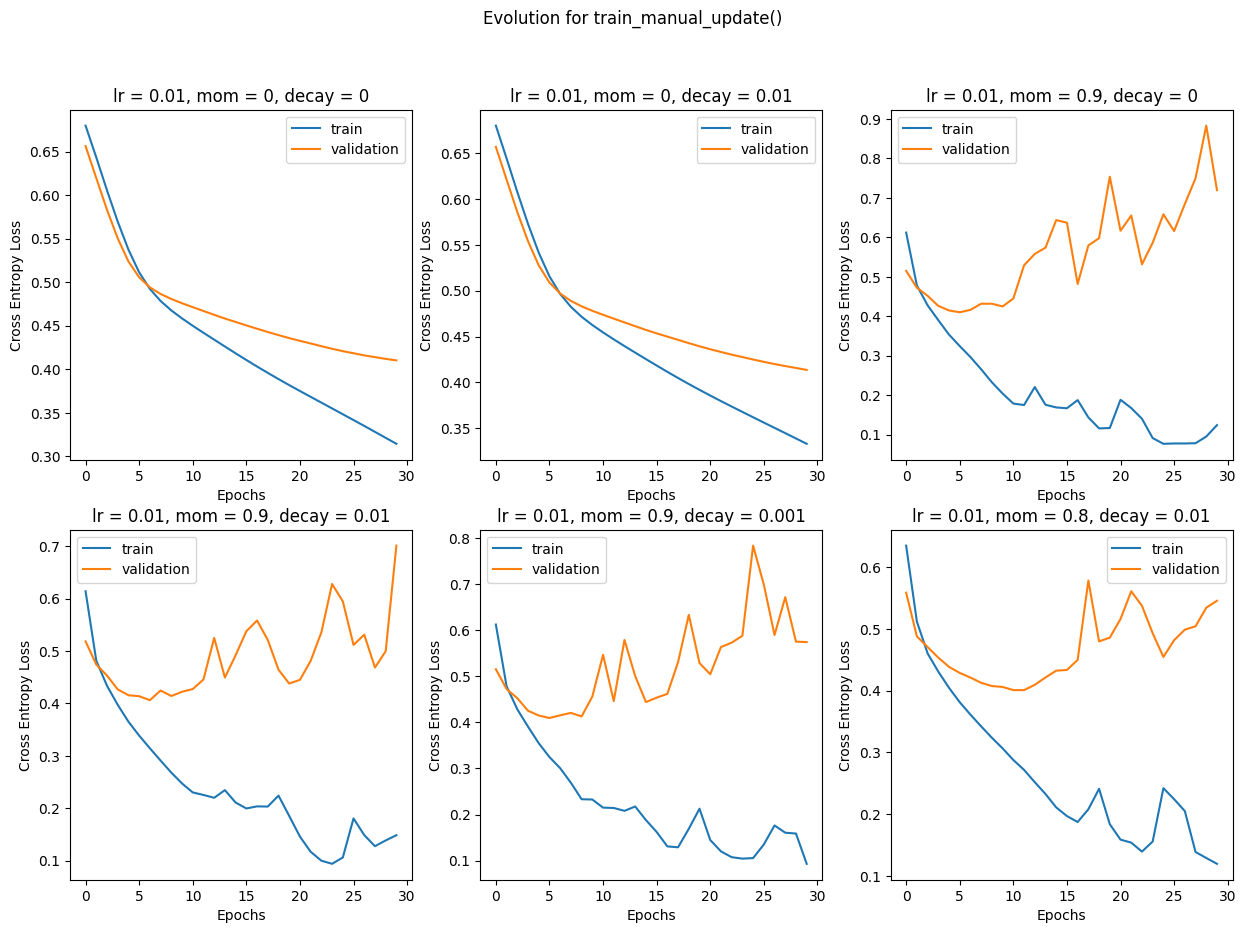

In [13]:
fig, axes = plt.subplots(2, 3, figsize=(15, 10))

for i, ax in enumerate(axes.flat):
    ax.plot(losses_train_manual_train[i], label='train')
    ax.plot(losses_val_manual_train[i], label='validation')
    ax.set_title(f"lr = {lr}, mom = {momentum[i]}, decay = {weight_decay[i]}")
    ax.set_xlabel('Epochs')
    ax.set_ylabel('Cross Entropy Loss')
    ax.legend()
fig.suptitle("Evolution for train_manual_update()")
plt.show()

In [14]:
def accuracy(expected, predicted):
    return accuracy_score(expected, predicted, normalize=False)

In [15]:
def compute_performance(model, loader, performance=accuracy, normalize=True, device=None, preprocessor=normalizer):
    device = set_device(device)

    model.eval()
    perf = 0
    n_tot = 0

    with torch.no_grad():
        for imgs, labels in loader:
            imgs = preprocessor(imgs.to(device=device))
            labels = labels.to(device=device)

            outputs = model(imgs)
            _, predicted = torch.max(outputs, dim=1)

            n_tot += len(imgs)
            perf += performance(labels.cpu(), predicted.cpu())

    if normalize:
        perf /= n_tot

    return perf

9. Select the best model among those trained in the previous question based on their accuracy.

In [16]:
def model_selection(models, data_train, data_val, device=None):
    device = set_device(device)

    perf_train, perf_val = [], []

    for i, model in enumerate(models):
        model.to(device=device)
        train_loader = torch.utils.data.DataLoader(data_train, batch_size=batch_size, shuffle=False)
        val_loader = torch.utils.data.DataLoader(data_val, batch_size=batch_size, shuffle=False)

        print(f"Model [{i + 1}] (lr = {lr}, mom = {momentum[i]}, decay = {weight_decay[i]})\n")

        acc = compute_performance(model, train_loader, accuracy, device=device)
        perf_train.append(acc)
        print(f"Training accuracy:     {round(acc, 5)}")
        acc = compute_performance(model, val_loader, accuracy, device=device)
        perf_val.append(acc)
        print(f"Validation accuracy:   {round(acc, 5)}")

        print("-" * 50)

    i_best_model = np.argmax(perf_val)
    return perf_train, perf_val, i_best_model

In [17]:
perf_train, perf_val, i_best_model = model_selection(train_models, cifar2_train, cifar2_val)
print(f"\nBest model is: Model [{i_best_model + 1}]")

On device cpu.
Model [1] (lr = 0.01, mom = 0, decay = 0)

Training accuracy:     0.87081
Validation accuracy:   0.84107
--------------------------------------------------
Model [2] (lr = 0.01, mom = 0, decay = 0.01)

Training accuracy:     0.86236
Validation accuracy:   0.83514
--------------------------------------------------
Model [3] (lr = 0.01, mom = 0.9, decay = 0)

Training accuracy:     0.93724
Validation accuracy:   0.84107
--------------------------------------------------
Model [4] (lr = 0.01, mom = 0.9, decay = 0.01)

Training accuracy:     0.88673
Validation accuracy:   0.78282
--------------------------------------------------
Model [5] (lr = 0.01, mom = 0.9, decay = 0.001)

Training accuracy:     0.98286
Validation accuracy:   0.85489
--------------------------------------------------
Model [6] (lr = 0.01, mom = 0.8, decay = 0.01)

Training accuracy:     0.95549
Validation accuracy:   0.82823
--------------------------------------------------

Best model is: Model [5]


10. Evaluate the best model and analyse its performance.

In [18]:
test_loader = torch.utils.data.DataLoader(cifar2_test, batch_size=batch_size, shuffle=False)
best_model = train_models[i_best_model]

test_acc = compute_performance(best_model, test_loader, accuracy)
print(f"Test performance of the best model:    {test_acc}")

On device cpu.
Test performance of the best model:    0.855
